<a href="https://colab.research.google.com/github/dantrica/cement-based-composites/blob/main/analytics_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Python module for analysis of experimental data from compressive mechanical loads (f), open circuit potential (OCP), and cyclic voltammetry (CV).</h1>

<div align="right">Daniel A. Triana-Camacho, PhD(c)<br>Jorge H. Quintero-Orozco, Dr.



# 0.0. Libraries to initialize the module.

## 0.1. Uploading Google Drive on the Colab server.

In [1]:
try: # Esto permite ejecución en ambiente local, sin afectar el uso en Colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    basePath = '/content/drive/My Drive/Colab_DanielTriana'
    %cd $basePath
except:
    pass

Mounted at /content/drive
/content/drive/My Drive/Colab_DanielTriana


## 0.2. Uploading system libraries

In [2]:
import sys
import os
working_dir = os.getcwd()
script_dir = os.path.join(working_dir, 'scripts')
if not script_dir in sys.path:
    sys.path.append(script_dir)

## 0.3. Importing the libraries: lmfit, pro_data, ... from the Colab directory in Google Drive.



In [4]:
!pip install openpyxl==3.0.7
import openpyxl
import pandas as pd
from pandas import ExcelWriter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping 
from scipy.interpolate import interp1d
import scipy.stats as sta
import scipy.optimize as opt
import scipy.integrate as integral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


# 1.0. Coupling between compressive mechanical loads and open circuit potential (OCP).

## 1.1. Selection of the specimen(s).

In [5]:
data = pd.read_excel('data/Medidas_GO.xlsx')
#path_list = data.path
#measure = ['OCP', 'f']

ss1 = input("Please select the specimens from (p39 - p50), for instance: p39 p44 ...] : ")

def to_list(string):
    li = list(string.split(" "))
    return li
picked_samples = to_list(ss1)

print('Chose specimen(s) is/are: ', picked_samples)

Please select the specimens from (p39 - p50), for instance: p39 p44 ...] : p39
Chose specimen(s) is/are:  ['p39']


## 1.2. Python dictionary that organizes the information by specimen "pxx" according to the user's selection.

In [ ]:
# Browse over the specimens
# On each specimen  browse over the relevant measures to create a new DataFrame
dic_info_by_sample = {}
dic_info_by_sample = dic_info_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  s_sample = data['specimen'] == ss1
  sx = data[s_sample]
  s_measure = (sx['measure'] == 'OCP') | (sx['measure'] == 'f')
  sx[s_measure] # DataFrame with electric-mechanic measurements by sample "pxx"
  dic_info_by_sample[ss1] = sx[s_measure] # DataFrames e-m by pxx into dictionary 

dic_info_by_sample

{'p39':                   time specimen measure serie measurement_date  \
 0  2022-05-10 22:18:00      p39     OCP     1       2022-04-06   
 12                 NaT      p39       f   NaN       2022-04-06   
 
    sample_fabrication_date                             path start_curing_date  \
 0               2020-02-29  20220406_e_Malaga/OCP_p39_1.txt        2020-03-02   
 12                     NaT          20220406_f_Malaga/f_p39               NaT   
 
    end_curing_date     concentration_nc   nc   energy      solvent  \
 0       2020-04-12  0.2259 g / 80 g H2O   GO  Branson  Agua tipo I   
 12             NaT                  NaN  NaN      NaN          NaN   
 
    electric_field                                            remarks  
 0         Ninguno  1)  Se preparó 0.2259 g de GO, el GO fue sonic...  
 12            NaN                                                NaN  }

## 1.3. Dictionary with the electrical and mechanical data sorted by specimen "pxx".

In [ ]:
dic_data_by_sample = {}
dic_data_by_sample = dic_data_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  e_data = np.loadtxt('data/'+dic_info_by_sample[ss1].path.values[0]) # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
  e_t = e_data[:,0]*1e-3 #columna 1 tiempo en [s]
  v = -e_data[:,1]*1e3 #columna 2 voltaje en [mV]
  i = -e_data[:,2]*1e6 #columna 3 corriente en [uA]

  m_data = pd.read_excel('data/'+dic_info_by_sample[ss1].path.values[1]+'.xlsx') # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
  m_data.columns = m_data.iloc[1]
  m_data = m_data.drop([0,1,2])
  m_t = m_data['Tiempo'] # Segundos
  f = m_data['Fuerza']*9.8067 # N
  pos = m_data['Posición'] # mm

  dic_data_by_sample[ss1] = np.array([e_t, v, i, m_t, f, pos])

dic_data_by_sample

<ipython-input-6-386cdafeea49>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dic_data_by_sample[ss1] = np.array([e_t, v, i, m_t, f, pos])


{'p39': array([array([  2.558,   3.558,   4.558,   5.558,   6.558,   7.558,   8.558,
                 9.558,  10.558,  11.558,  12.558,  13.558,  14.558,  15.558,
                16.558,  17.558,  18.558,  19.558,  20.558,  21.558,  22.558,
                23.558,  24.558,  25.558,  26.558,  27.558,  28.558,  29.558,
                30.558,  31.558,  32.558,  33.558,  34.558,  35.558,  36.558,
                37.558,  38.558,  39.558,  40.558,  41.558,  42.558,  43.558,
                44.558,  45.558,  46.558,  47.558,  48.558,  49.558,  50.558,
                51.558,  52.558,  53.558,  54.558,  55.558,  56.558,  57.558,
                58.558,  59.558,  60.558,  61.558,  62.558,  63.558,  64.558,
                65.558,  66.558,  67.558,  68.558,  69.558,  70.558,  71.558,
                72.558,  73.558,  74.558,  75.558,  76.558,  77.558,  78.558,
                79.558,  80.558,  81.558,  82.558,  83.558,  84.558,  85.558,
                86.558,  87.558,  88.558,  89.558,  90.55

## 1.4. Interpolation for the voltage $v$, current $i$, force $F$, and deformation $\Delta L$ as a function of the time $t$.

In [ ]:
def interpol(samples, dic_data, t_min_max=[2, 150], n=200):
  dic_idata_by_sample = {}
  dic_idata_by_sample = dic_idata_by_sample.fromkeys(samples)

  for ss2 in dic_data.keys():
    # medidas eléctricas
    e_t = dic_data[ss2][0] # índice "0": tiempo en [s]
    v = dic_data[ss2][1] # índice "1": voltaje en [mV]
    i = dic_data[ss2][2] # índice "2": corriente en [uA]

    # medidas mecánicas
    m_t = dic_data[ss2][3] # índice "3": tiempo en [s]
    try: # solución al error de np.array no tiene atributo values 
      m_tmi = m_t.values[0]
      m_tma = m_t.values[-1]
    except:
      m_tmi = m_t[0]
      m_tma = m_t[-1]
    f = dic_data[ss2][4] # índice "4": fuerza en [kN]
    pos = dic_data[ss2][5] #- dic_data[ss2][5].max() # índice "5": deformación en [mm]

    # interpolación de variables dependientes del tiempo v, i, f, pos
    interpol_v = interp1d(e_t, v)
    interpol_i = interp1d(e_t, i)
    interpol_f = interp1d(m_t, f)
    interpol_pos = interp1d(m_t, pos)
    
    # Determinación del intervalo de tiempo  tmin y tmax
    if e_t[0] < m_tmi: #m_t.values[0]:
      t_min = m_tmi#m_t.values[0]
    else:
      t_min = e_t[0]
    if e_t[-1] < m_tma: #m_t.values[-1]:
      t_max = e_t[-1]
    else:
      t_max = m_tma#m_t.values[-1]

    if t_min_max[0] <= t_min:
      print('You must select a time greater than %.2f [s]' %t_min)
    else:
      t_min = t_min_max[0]
    if t_min_max[-1] >= t_max:
      print('You must select a time less than %.2f %.2f [s]' %t_max)
    else:
      t_max = t_min_max[-1]

    i_t = np.linspace(t_min, t_max, n)

    dic_idata_by_sample[ss2] = np.array([i_t, interpol_v(i_t), interpol_i(i_t), 
                                         i_t, interpol_f(i_t), interpol_pos(i_t)])
    
  return dic_idata_by_sample

## 1.5. Method for plotting that gives a relationship between $v(t)$, $i(t)$, $F(t)$ y $\Delta L(t)$.

In [ ]:
def plot_electromechanical(data, idata, option=0, marker='--', etiqueta='',
                           label_axes='en', dpi=90):
  ax = plt.figure(num=0, dpi = dpi)

  if label_axes == 'sp':
      # Labels of physic quantities en
    time = 'Tiempo'
    force = 'Fuerza'
    strain = 'Deformación'
    uni_strain = r'Deformación unitaria'
    voltage = 'Voltaje'
    current = r'Corriente'
    resistence = r'Resistencia'
    DR_R0 = r'$\frac{\Delta R}{R_0}$'
    power = 'Potencia'
    force_area = r'$\frac{F}{A}$'
    voltage_distance = r'$\frac{V}{d}$'
  elif label_axes == 'en':  
    # Labels of physic quantities en
    time = 'Time'
    force = 'Load' # 'Strength'
    strain = 'Deformation'
    uni_strain = r'Strain'
    voltage = 'Voltage'
    current = r'Current'
    resistence = r'Resistance'
    DR_R0 = r'$\Delta R/R_0$'
    power = 'Power'
    force_area = r'Stress'
    voltage_distance = r'$\frac{V}{d}$'
  else:
    print('Error in labels')

  # Units
  u_time = ' [s]'
  u_force = ' [N]'
  u_strain = ' [mm]'
  u_uni_strain = r' [$\mu \epsilon$]'
  u_voltage = ' [mV]'
  u_current = r' [$\mu$A]'
  u_resistence = r' [k$\Omega$]'
  u_DR_R0 = r' [$\Omega/\Omega$]'
  u_power = ' [nW]'
  u_force_area = r' [$N/m^2$]'
  u_voltage_distance = r' [$V/m$]'


  for ss2 in picked_samples:

    # medidas eléctricas
    e_t = data[ss2][0] # índice "0": tiempo en [s]
    v = data[ss2][1] # índice "1": voltaje en [mV]
    i = data[ss2][2] # índice "2": corriente en [uA]

    i_e_t = idata[ss2][0] # índice "0": tiempo en [s]
    i_v = idata[ss2][1] # índice "1": voltaje en [mV]
    i_i = idata[ss2][2] # índice "2": corriente en [uA]

    # medidas mecánicas
    m_t = data[ss2][3] # índice "3": tiempo en [s]
    f = data[ss2][4] # índice "4": fuerza en [N]
    pos = data[ss2][5] # índice "5": deformación en [mm]

    i_m_t = idata[ss2][3] # índice "3": tiempo en [s]
    i_f = idata[ss2][4] # índice "4": fuerza en [N]
    i_pos = idata[ss2][5] # índice "5": deformación en [mm]

    norm = ''

    if option == 0:
      x, y, xlabel, ylabel = i_m_t, i_f, time+u_time, force+u_force
    elif option == 1:
      x, y, xlabel, ylabel = i_m_t, i_pos/60 * 1e6, time+u_time, uni_strain+u_uni_strain
    elif option == 2:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_f, uni_strain+u_uni_strain, force+u_force
    elif option == 3:
      x, y, xlabel, ylabel = i_e_t, i_v, time+u_time, voltage+u_voltage
    elif option == 4:
     x, y, xlabel, ylabel = i_e_t, i_i, time+u_time, current+u_current
    elif option == 5:
      x, y, xlabel, ylabel = i_v, i_i, voltage+u_voltage, current+u_current
    elif option == 6:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_v, uni_strain+u_uni_strain, voltage+u_voltage
    elif option == 7:
      x, y, xlabel, ylabel = i_f, i_v, force+u_force, voltage+u_voltage
    elif option == 8:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_i, uni_strain+u_uni_strain, current+u_current
    elif option == 9:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_v/i_i, uni_strain+u_uni_strain, resistence+u_resistence
    elif option == 10:
      x, y, xlabel, ylabel = i_f, i_v/i_i, force+u_force, resistence+u_resistence
    elif option == 11:
      x, y, xlabel, ylabel = i_e_t, i_v * i_i, time+u_time, power+u_power
    elif option == 12:
      x, y, xlabel, ylabel = i_e_t, i_v / i_i, time+u_time, resistence+u_resistence
    elif option == 13:
      R = i_v / i_i
      R0 = R.min()
      DR = R - R0
      x, y, xlabel, ylabel = i_pos/60 * 1e6, DR / R0, uni_strain+u_uni_strain, DR_R0+u_DR_R0
    elif option == 14:
      R = i_v / i_i
      R0 = R.min()
      DR = R - R0
      x, y, xlabel, ylabel = i_e_t, DR / R0, time+u_time, DR_R0
    elif option == 15:
      x, y, xlabel, ylabel = i_f*1e3 / (np.pi*(15e-3)**2), i_v*1e-3 / ( 20e-3 ), force_area+u_force_area, voltage_distance+u_voltage_distance
    elif option == 16:
      norm = 'Normalizada'
      x, y, xlabel, ylabel = i_m_t, i_pos/i_pos.max(), time+u_time, uni_strain+' '+norm
    elif option == 17:
      norm = 'Normalizada'
      x, y, xlabel, ylabel = i_e_t, i_i/i_i.max(), time+u_time, current+' '+norm
    elif option == 18:
      x, y, xlabel, ylabel = i_pos/60 * 1e6, i_v * i_i, uni_strain+u_uni_strain, power+u_power
    
    # ------ Rutina temporal para regresión lineal -----------------------------
    x = x.astype('float')
    y = y.astype('float')
    y_m = ( y.max() + y.min() ) / 2 
    regre = sta.linregress(x, y)
    #print(regre)
    print('g_33 = ', regre.slope/20e-3*np.pi*(15e-3)**2*1e5, r' *10^{-5} mVm/N') # g33
    print('\n')
    # print(regre.slope/1e6*1e12, r' pC/N') # d33
    #print(y_m)
    #print((y - y_m).max())
    # --------------------------------------------------------------------------

    if etiqueta == '':
      lab = ss2
    else:
      lab = etiqueta
    # Graficación de datos por muestra "pxx"
    if norm == 'Normalizada':
      plt.plot(x, y, marker, label=lab+' '+ylabel)
      plt.xlabel(xlabel)
      plt.ylabel(norm)
      plt.title(norm+' vs '+xlabel)
    else:
      plt.plot(x, y, marker, label=lab)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.title(ylabel+' vs '+xlabel)
    plt.legend()
  #plt.ylim(-5, 31) # modificar para voltaje_load

  #plt.show()
  return xlabel, ylabel, ax, regre

# 2.0. Calling the methods and data presentation.

## 2.1. Plotting options

g_33 =  12.194347822096718  *10^{-5} mVm/N




"\nax = plt.gca() # get axis handle\nline = ax.lines[0] # get the first line, there might be more\nx = line.get_xdata() # get x data from figure\ny = line.get_ydata() # get y data from figure\n\nsave_VL = 'outputs/fig_GO/'\ntemp_file = open(save_VL+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+\n                    xylabel[0].split(' ')[0]+'.txt', mode='w+')\nfor s in np.arange(len(x)):\n   temp_file.write('%0.3f %0.3f\n' %(x[s], y[s]))\ntemp_file.close()\n"

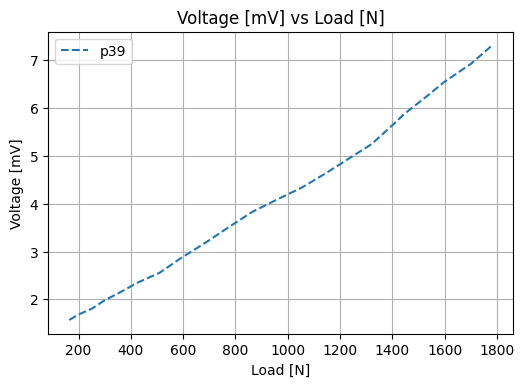

In [ ]:
'''
There are xx options (0 - XX) to choose the figure to be plotted, 
according to set of specimens 'pxx'
option = 0 --- force vs time
option = 1 --- strain vs time
option = 2 --- force vs strain
option = 3 --- voltage vs time
option = 4 --- current vs time
option = 5 --- current vs voltage
option = 6 --- voltage vs strain
option = 7 --- voltage vs force
option = 8 --- current vs strain
option = 9 --- resistance vs strain
option = 10 --- resistance vs force
option = 11 --- potencia vs time
option = 12 --- resistance vs time
option = 13 --- Delta resistance / R vs strain
option = 14 --- Delta resistance / R vs time
option = 15 --- voltage / electrodes separation vs force / cross section
option = 16 --- nomalized strain vs time
option = 17 --- normalized current vs time
option = 18 --- power vs strain
'''
idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,13], n=500)
data = dic_data_by_sample

xylabel = plot_electromechanical(data, idata, option=7, marker='--', 
                                 etiqueta='', label_axes='en', dpi=100)

plt.grid()
'''
ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

save_VL = 'outputs/fig_GO/'
temp_file = open(save_VL+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+
                    xylabel[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x)):
   temp_file.write('%0.3f %0.3f\n' %(x[s], y[s]))
temp_file.close()
'''

## 2.2. Power vs Time and Energy calculations

g_33 =  58.96768298772441  *10^{-5} mVm/N


371.77375291780623  [nJ]


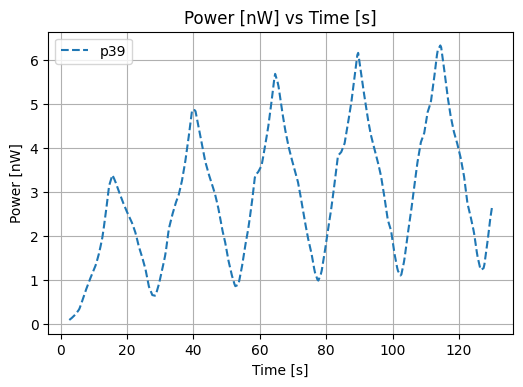

In [ ]:
'''
Here are the options to choose a time dependence of the electrical and mechanical data series, 
given a set of specimens.
option = 0 --- fuerza vs tiempo
option = 3 --- voltaje vs tiempo
option = 4 --- corriente vs tiempo
option = 11 --- potencia vs tiempo
option = 12 --- resistencia vs tiempo
option = 14 --- Delta de resistencia / R vs tiempo
option = 16 --- deformación unitaria normalizada vs tiempo
option = 17 --- corriente normalizada vs tiempo

It has been selected the option = 11 --- power vs time
'''
idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,130], n=500)
data = dic_data_by_sample

xylabel = plot_electromechanical(data, idata, option=11, marker='--', etiqueta='',
                                 label_axes='en', dpi=100)

plt.grid()
ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

a = integral.simps(y, x)
print(a, ' [nJ]')

save_VL = 'outputs/fig_GO/'
temp_file = open(save_VL+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+
                    xylabel[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x)):
   temp_file.write('%0.3f %0.3f\n' %(x[s], y[s]))
temp_file.close()

## 2.3. Comparison between strain and other variables wich are time function

g_33 =  -436.5709292206754  *10^{-5} mVm/N


g_33 =  861.5854324799959  *10^{-5} mVm/N




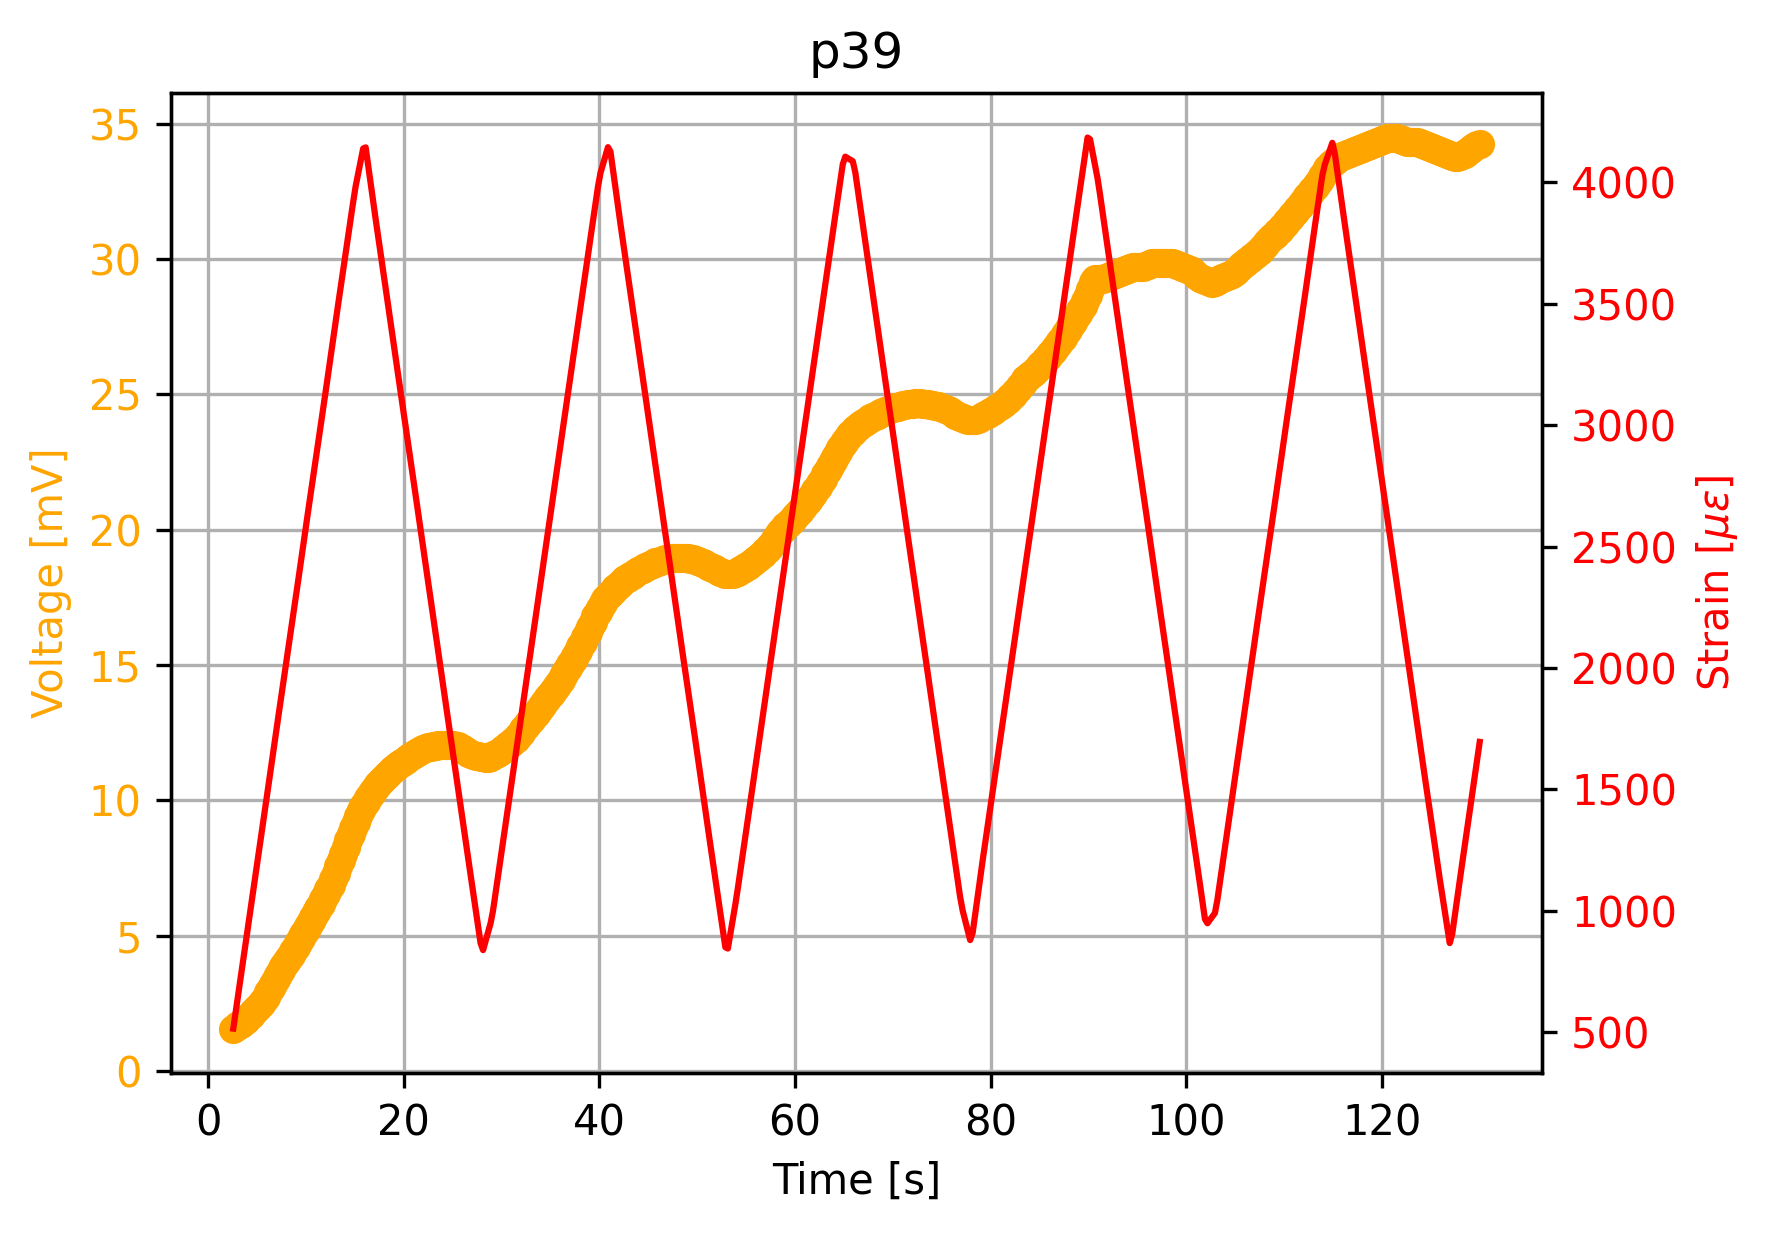

In [ ]:
'''
Here are the options to choose a time dependence of the electrical and mechanical data series, 
given a set of specimens.
option = 0 --- fuerza vs tiempo
option = 3 --- voltaje vs tiempo
option = 4 --- corriente vs tiempo
option = 11 --- potencia vs tiempo
option = 12 --- resistencia vs tiempo
option = 14 --- Delta de resistencia / R vs tiempo
option = 16 --- deformación unitaria normalizada vs tiempo
option = 17 --- corriente normalizada vs tiempo

Then, the strain timeline (option = 16) is compared with the above options
'''
idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,130], n=500)
data = dic_data_by_sample

strain = plot_electromechanical(data, idata, option=1, marker='--', etiqueta='', dpi=100)
ax1 = plt.gca() # get axis handle
line = ax1.lines[0] # get the first line, there might be more
x_strain = line.get_xdata() # get x data from figure
y_strain = line.get_ydata() # get y data from figure
plt.close()
#plt.plot(x_strain, y_strain, '.b')

other = plot_electromechanical(data, idata, option=3, marker='--', etiqueta='', dpi=100)
ax2 = plt.gca() # get axis handle
line = ax2.lines[0] # get the first line, there might be more
x_other = line.get_xdata() # get x data from figure
y_other = line.get_ydata() # get y data from figure
plt.close()
#plt.plot(x_other, y_other, '.r')

fig, ax3 = plt.subplots(dpi=300)

color = 'orange'
ax3.set_xlabel(other[0])
ax3.set_ylabel(other[1], color=color)
h1 = ax3.plot(x_other, y_other, color=color, marker='o', label='Experimental')
ax3.tick_params(axis='y', labelcolor=color)
ax3.grid('both')

#-------------------------------------------------------------------------------
# Only for simulated voltage and voltage measurements
#fname = 'OCP_'+picked_samples[0]+'_sim.png'
#get_path = 'data/20220406_e_Malaga/'
#OCP = np.loadtxt(get_path+'OCP_'+picked_samples[0]+'_sim.txt')
#ts = OCP[:,0]
#vs = OCP[:,1]
#isim = OCP[:,2]

#ax4.grid('both')
#ax3.plot(ts, vs*1000, '-k', label='Theoretical')
#ax3.legend()
#-------------------------------------------------------------------------------

ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis

color='red'
ax4.set_ylabel(strain[1], color=color)
h2 = ax4.plot(x_strain, y_strain, color=color, marker='')
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(picked_samples[0])
plt.show()

xylabel = [other[0], other[1], fig, 0]

save_data = 'outputs/fig_GO/'
temp_file = open(save_data+picked_samples[0]+'_'+other[1].split(' ')[0]+'_'+
                    other[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x_other)):
   temp_file.write('%0.3f %0.3f\n' %(x_other[s], y_other[s]))
temp_file.close()

# 3.0. Simulation vs measure data

<div align="left">In 1.1. In order to compare the experimental and simulated data you must choose a unique specimen between p39, and p45. Before, be must compile from 1.1 until 1.5.





## 3.1. Timeline of the piezovoltage

g_33 =  838.1688620868669  *10^{-5} mVm/N




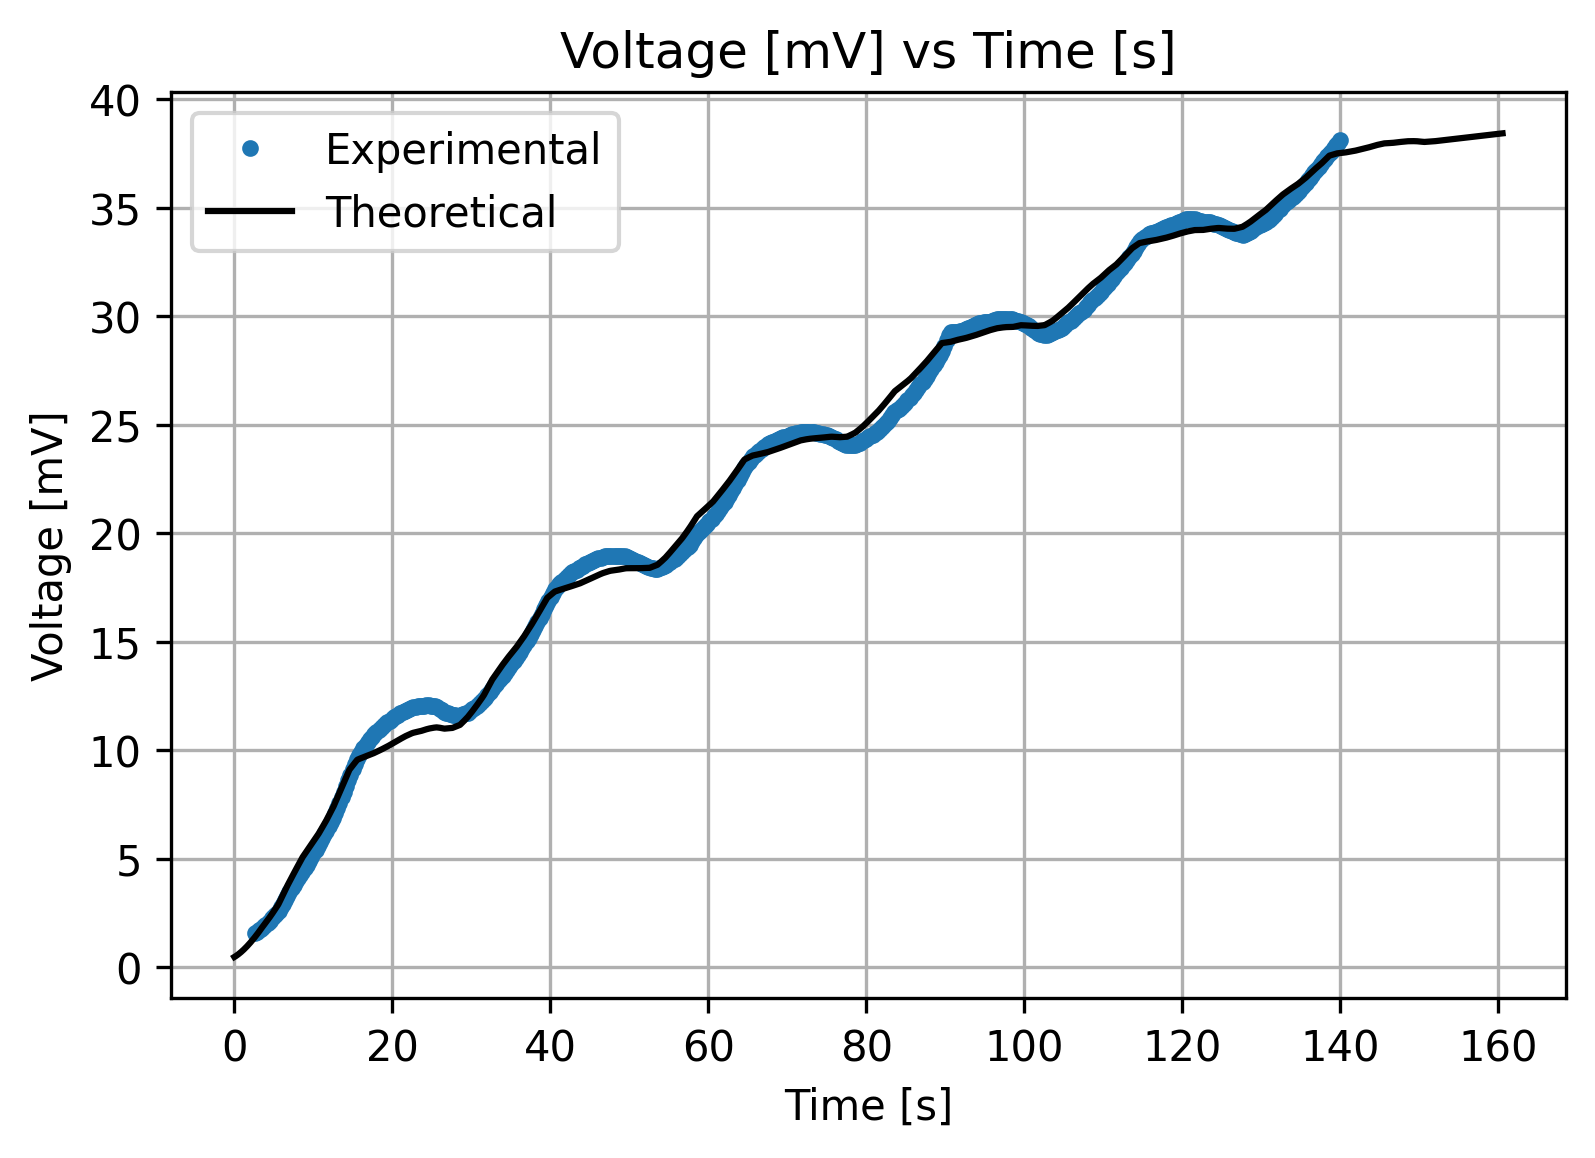

In [ ]:
'''
Be must compile from 1.1 until 1.5
'''

fname = 'OCP_'+picked_samples[0]+'_sim.png'
dname = 'OCP_'+picked_samples[0]+'_sim_final.txt'
get_path = 'data/20220406_e_Malaga/'
save_fpath = 'outputs/fig_GO/simulated/'

idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,140], n=500)
data = dic_data_by_sample

xylabel = plot_electromechanical(data, idata, option=3, marker='.', 
                                 etiqueta='Experimental', dpi=300)

ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

voltage_time = open(save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+
                    xylabel[0].split(' ')[0]+'.txt', mode='w+')
for s in np.arange(len(x)):
   voltage_time.write('%0.3f %0.3f\n' %(x[s], y[s]))
voltage_time.close()

OCP = np.loadtxt(get_path+dname)
ts = OCP[:,0]
vs = OCP[:,1]
isim = OCP[:,2]

plt.grid('both')
plt.plot(ts, vs*1000, '-k', label='Theoretical')
plt.legend()
#plt.plot(ts, vs, '-k')

plt.savefig(save_fpath+fname, dpi=300)

## 3.2. $\Delta R/R_0$ vs strain

g_33 =  -17.729537976110176  *10^{-5} mVm/N


outputs/fig_GO/simulated/p39_$\Delta_Strain_experimental.txt outputs/fig_GO/simulated/p39_$\Delta_Strain_sim.txt


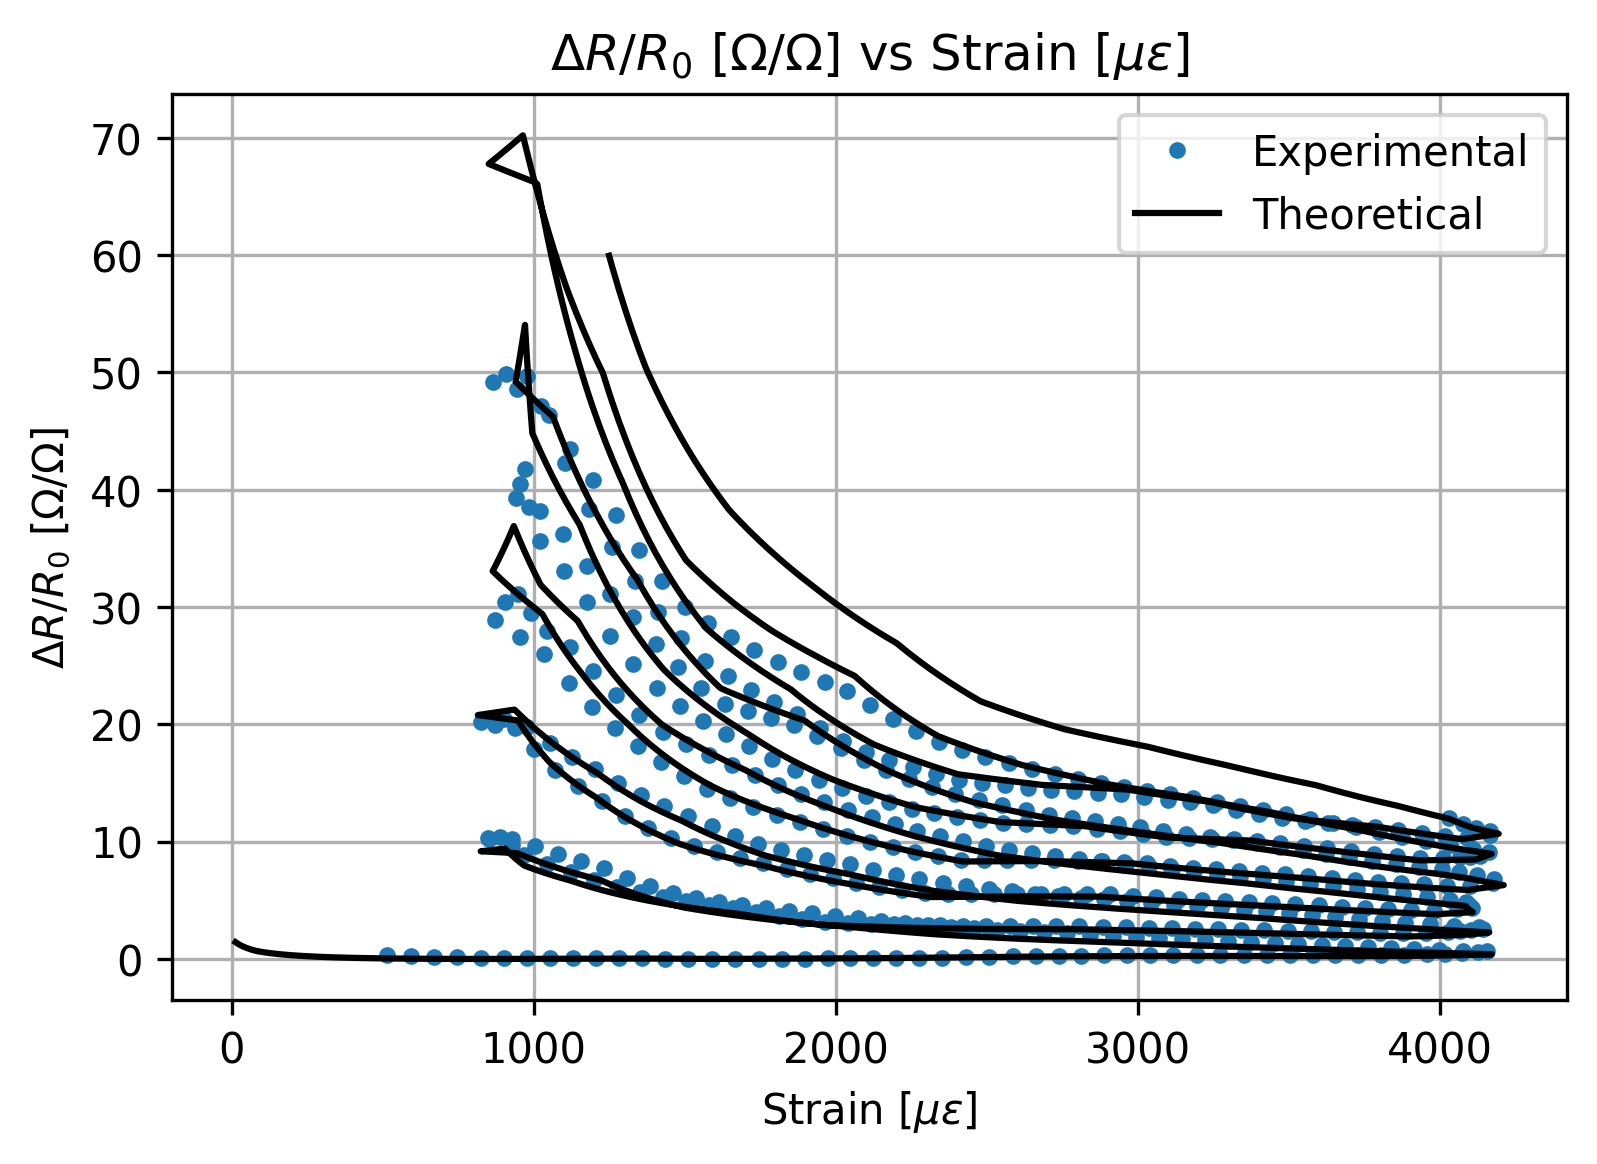

In [ ]:
# se debe compilar desde 1.1 hasta 1.5

dname = 'OCP_'+picked_samples[0]+'_sim_final.txt'
get_path = 'data/20220406_e_Malaga/'
save_fpath = 'outputs/fig_GO/simulated/'

idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,140], n=500)
data = dic_data_by_sample
xylabel = plot_electromechanical(data, idata, option=13, marker='.', 
                                 etiqueta='Experimental', dpi=300)

ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

name1 = save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+xylabel[0].split(' ')[0]+'_experimental.txt'
exp_strain = open(name1, mode='w+')
for s in np.arange(len(x)):
   exp_strain.write('%0.3f %0.3f\n' %(x[s], y[s]))
exp_strain.close()

OCP = np.loadtxt(get_path+dname, skiprows=17)
ts = OCP[:,0]
vs = OCP[:,1]
isim = OCP[:,2]
strain1 = OCP[:,3]/60 *1e6
Rsim = vs/isim
FCR1 = ( Rsim - Rsim.min() ) / Rsim.min()
ks = ts<=150
strain = strain1[ks]
FCR = FCR1[ks]

name2 = save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+xylabel[0].split(' ')[0]+'_sim.txt'
sim_strain = open(name2, mode='w+')
for ls in np.arange(len(strain)):
   sim_strain.write('%0.3f %0.3f\n' %(strain[ls], FCR[ls]))
sim_strain.close()

plt.grid('both')
plt.plot(strain, FCR, '-k', label='Theoretical')
plt.legend()

fname = 'FCR_'+picked_samples[0]+'_sim.png'
plt.savefig(save_fpath+fname, dpi=300)
print(name1, name2)

## 3.3. Power vs strain

g_33 =  4.874111429946449  *10^{-5} mVm/N


outputs/fig_GO/simulated/p39_Power_Strain_experimental.txt outputs/fig_GO/simulated/p39_Power_Strain_sim.txt


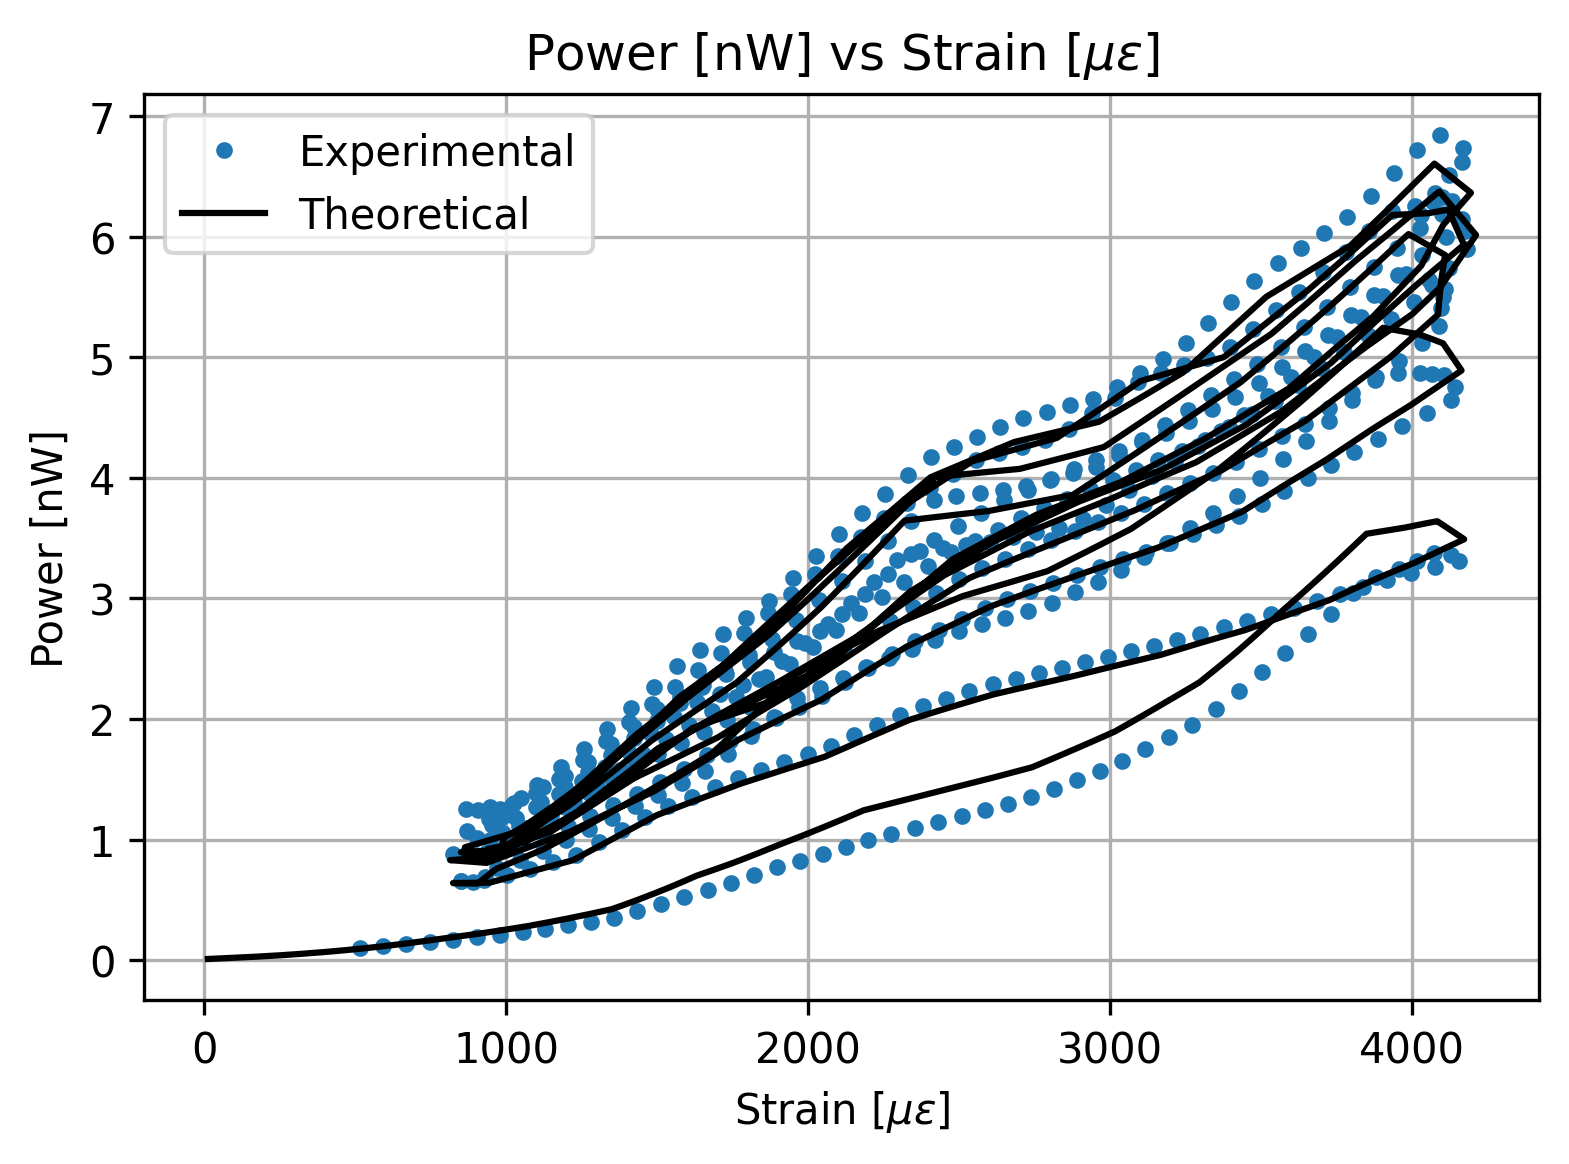

In [ ]:
# se debe compilar desde 1.1 hasta 1.5 power strain
dname = 'OCP_'+picked_samples[0]+'_sim_final.txt'
get_path = 'data/20220406_e_Malaga/'
save_fpath = 'outputs/fig_GO/simulated/'

idata = interpol(samples=picked_samples, dic_data=dic_data_by_sample,
                 t_min_max=[2.56,140], n=500)
data = dic_data_by_sample
xylabel = plot_electromechanical(data, idata, option=18, marker='.', 
                                 etiqueta='Experimental', dpi=300)

ax = plt.gca() # get axis handle
line = ax.lines[0] # get the first line, there might be more
x = line.get_xdata() # get x data from figure
y = line.get_ydata() # get y data from figure

name1 = save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+xylabel[0].split(' ')[0]+'_experimental.txt'
exp_strain = open(name1, mode='w+')
for s in np.arange(len(x)):
   exp_strain.write('%0.3f %0.3f\n' %(x[s], y[s]))
exp_strain.close()

OCP = np.loadtxt(get_path+dname, skiprows=17)
ts = OCP[:,0]
vs = OCP[:,1]
isim = OCP[:,2]
strain1 = OCP[:,3]/60 *1e6
Rsim = vs/isim
FCR1 = ( Rsim - Rsim.min() ) / Rsim.min()

ks = ts<=150
strain = strain1[ks]
FCR = FCR1[ks]
power = vs[ks]*isim[ks]*1.1e9


name2 = save_fpath+picked_samples[0]+'_'+xylabel[1].split(' ')[0]+'_'+xylabel[0].split(' ')[0]+'_sim.txt'
sim_strain = open(name2, mode='w+')
for ls in np.arange(len(strain)):
   sim_strain.write('%0.3f %0.3f\n' %(strain[ls], power[ls]))
sim_strain.close()

plt.grid('both')
plt.plot(strain, power, '-k', label='Theoretical')
plt.legend()

fname = 'power_'+picked_samples[0]+'_sim.png'
plt.savefig(save_fpath+fname, dpi=300)
print(name1, name2)

## 3.4. Circuit model params.

In [ ]:
L_1 = np.array([0.15, 0.15, 0.15])
L_2 = np.array([0.10, 0.10, 0.06])

rm_1 = np.array([2826.30, 2739.50, 3131.50])
rm_2 = np.array([2142.00, 2167.40, 2039.50])

cm_1 = np.array([237.73, 395.78, 290.29 ])
cm_2 = np.array([454.05, 414.04, 380.48])

rct_1 = np.array([9.16, 13.25, 10.51])
rct_2 = np.array([5.99, 7.51, 4.79])

print(r'L_m1 = %0.2f +/- %0.2f' %( L_1.mean(), L_1.std()) )
print(r'L_m2 = %0.2f +/- %0.2f' %( L_2.mean(), L_2.std()) )

print(r'Rm_m1 = %0.2f +/- %0.2f' %( rm_1.mean(), rm_1.std()) )
print(r'Rm_m2 = %0.2f +/- %0.2f' %( rm_2.mean(), rm_2.std()) )

print(r'C_m1 = %0.2f +/- %0.2f' %( cm_1.mean(), cm_1.std()) )
print(r'C_m2 = %0.2f +/- %0.2f' %( cm_2.mean(), cm_2.std()) )

print(r'Rct_m1 = %0.2f +/- %0.2f' %( rct_1.mean(), rct_1.std()) )
print(r'Rct_m2 = %0.2f +/- %0.2f' %( rct_2.mean(), rct_2.std()) )

L_m1 = 0.15 +/- 0.00
L_m2 = 0.09 +/- 0.02
Rm_m1 = 2899.10 +/- 168.11
Rm_m2 = 2116.30 +/- 55.29
C_m1 = 307.93 +/- 65.72
C_m2 = 416.19 +/- 30.07
Rct_m1 = 10.97 +/- 1.70
Rct_m2 = 6.10 +/- 1.11


# 4.0. Analysis voltammograms

In 1.1. be must select just one specimen, between p39, p40 y p41

In [ ]:
# Recorrer sobre las muestras
# En cada muestra recorrer sobre las medidas de interes para crear un nuevo data frame

dic_info_by_sample = {}
dic_info_by_sample = dic_info_by_sample.fromkeys(picked_samples)

for ss1 in picked_samples:
  s_sample = data['specimen'] == ss1
  sx = data[s_sample]
  s_measure = (sx['measure'] == 'CV')
  sx[s_measure] # DataFrame with electric-mechanic measurements by sample "pxx"
  dic_info_by_sample[ss1] = sx[s_measure] # DataFrames e-m by pxx into dictionary 

dic_info_by_sample

{'p39':    time specimen measure    serie measurement_date sample_fabrication_date  \
 24  NaT      p39      CV    0kg_2       2022-04-06                     NaT   
 25  NaT      p39      CV   50kg_2       2022-04-06                     NaT   
 26  NaT      p39      CV  100kg_2       2022-04-06                     NaT   
 27  NaT      p39      CV  150kg_2       2022-04-06                     NaT   
 28  NaT      p39      CV  200kg_2       2022-04-06                     NaT   
 29  NaT      p39      CV  250kg_2       2022-04-06                     NaT   
 45  NaT      p39      CV    0kg_1       2022-07-02                     NaT   
 
                                     path start_curing_date end_curing_date  \
 24    20220406_e_Malaga/CV_p39_0kg_2.txt               NaT             NaT   
 25   20220406_e_Malaga/CV_p39_50kg_2.txt               NaT             NaT   
 26  20220406_e_Malaga/CV_p39_100kg_2.txt               NaT             NaT   
 27  20220406_e_Malaga/CV_p39_150kg_2.txt  

In [ ]:
# Diccionario con los datos eléctricos de los voltamperogramas de cada muestra pxx a diferentes fuerzas

dic_data_by_load = {}

for ss1 in picked_samples:
  for ss2 in dic_info_by_sample[ss1].path.values:
    sl1 = ss2.split("kg") # separa path en una lista donde el elemento 5 es la carga en kg
    sl2 = list(sl1[0].split("_"))
    e_data = np.loadtxt('data/'+ss2) # indice 1 : muestra, indice 2 : path de la medida, electrica [0] o mecánica [1]
    #print(ss2)
    e_t = e_data[:,0]*1e-3 #columna 1 tiempo en [s]
    v = e_data[:,1]*1e3 #columna 2 voltaje en [mV]
    i = e_data[:,2]*1e6 #columna 3 corriente en [uA]
    
    dic_data_by_load[ss1+'_'+sl2[4]] = np.array([e_t, v, i])

#dic_data_by_load

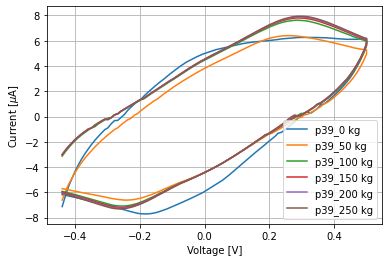

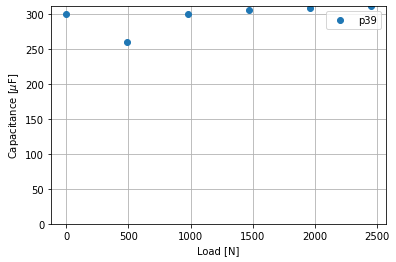

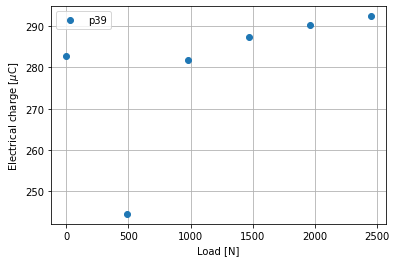

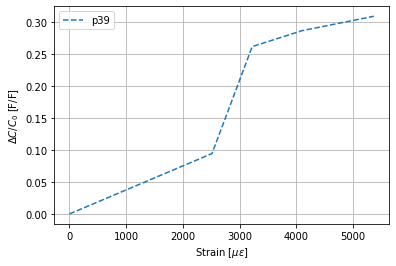

[   0.         2514.85622012 3223.93484791 4103.18768981 4829.99231319
 5369.78923541] [0.         0.09421113 0.26105867 0.28595646 0.29882389 0.30846079]


In [ ]:
dpi = 300
plt.figure(1)
fname_cv = 'CV_'+picked_samples[0]+'.png'
fname_c = 'C_'+picked_samples[0]+'.png'
fname_cs = 'FCC_strain_'+picked_samples[0]+'.png'
fname_q = 'Q_'+picked_samples[0]+'.png'
save_fpath = 'outputs/fig_GO/voltammetry/'

data_C = open(save_fpath+'cap_'+picked_samples[0]+'.txt', mode='w+')
data_q = open(save_fpath+'charge_'+picked_samples[0]+'.txt', mode='w+')

dic_cap = {}
dic_q = {}
xc = []
yc = []
xq = []
yq = []

for ss2 in dic_data_by_load.keys():
  # medidas eléctricas
  e_t = dic_data_by_load[ss2][0] # índice "0": tiempo en [s]
  v = dic_data_by_load[ss2][1]/1e3 # índice "1": voltaje en [V]
  i = dic_data_by_load[ss2][2] # índice "2": corriente en [uA]

  sj = int(len(v)/2)  
  i1 = i[0:sj]
  v1 = v[0:sj]
  i2 = i[sj:len(v)]
  v2 = v[sj:len(v)]
  
  vmin = -0.44
  vmax = v.max()

  ss = (v >= vmin) & (v <= vmax)
  ss0 = (v1 >= vmin) & (v1 <= vmax)
  ss1 = (v2 >= vmin) & (v2 <= vmax)

  iaux1 = i1[ss0] - i2.min()
  vaux1 = v1[ss0]
  iaux2 = i2[ss1] - i2.min()
  vaux2 = v2[ss1]
  
  a1 = integral.simps(iaux1, vaux1)
  a2 = integral.simps(iaux2, vaux2)
  a = a1 - a2 # integral de la corriente en función del voltaje en la ventana de portencial
  dic_cap[ss2] = 0.5 * a / 25e-3 / (vmax - vmin) # capacitancia para cada carga mecánica [uF]
  dic_q[ss2] = 0.5 * a / 25e-3 # carga eléctrica para cada carga mecánica [uC]

  #-----------------------------------------------------------------------------
  # salvar datos de capacitancia y carga eléctrica en .txt y en listas xc y yc
  xc_s = float(ss2.split('_')[1])*9.8067 # N
  yc_s = dic_cap[ss2]
  xc = np.append(xc, xc_s)
  yc = np.append(yc, yc_s)
  data_C.write('%0.3f %0.3f\n' %(xc_s, yc_s))

  xq_s = float(ss2.split('_')[1])*9.8067 # N
  yq_s = dic_q[ss2]
  xq = np.append(xq, xq_s)
  yq = np.append(yq, yq_s)
  data_q.write('%0.3f %0.3f\n' %(xq_s, yq_s))
  #-----------------------------------------------------------------------------

  plt.plot(v[ss], i[ss], '-', label=ss2+' kg')

yc.std()

xs = np.array([0, 0.150891373207065, 0.193436090874833, 0.24619126138889,
               0.289799538791274, 0.322187354124785])
ycc = np.array([237.732, 260.129, 299.794, 305.713, 308.772, 311.063])
strain = xs/60*1e6
DC = ( ycc-ycc.min() )/ycc.min()

data_C.close()
data_q.close()

plt.xlabel(r'Voltage [V]')
plt.ylabel(r'Current [$\mu$A]')
plt.grid()
plt.legend()
plt.savefig(save_fpath+fname_cv, dpi=dpi)
plt.show()

plt.figure(2)
plt.plot(xc, yc, 'o', label=picked_samples[0])
plt.xlabel(r'Load [N]')
plt.ylabel(r'Capacitance [$\mu$F]')
plt.ylim(0, yc.max())
plt.grid()
plt.legend()
plt.savefig(save_fpath+fname_c, dpi=dpi)
plt.show()

plt.figure(3)
plt.plot(xq, yq, 'o', label=picked_samples[0])
plt.xlabel(r'Load [N]')
plt.ylabel(r'Electrical charge [$\mu$C]')
plt.grid()
plt.legend()
plt.savefig(save_fpath+fname_q, dpi=dpi)
plt.show()

plt.figure(4)
plt.plot(strain, DC, '--', label=picked_samples[0])
plt.xlabel(r'Strain [$\mu\epsilon$]')
plt.ylabel(r'$\Delta C/C_0$ [F/F]')
plt.grid()
plt.legend()
plt.savefig(save_fpath+fname_cs, dpi=dpi)
plt.show()
print(strain, DC)

## 4.1. Piezoelectric parameter of charge $d_{33}$

In [ ]:
# calculo d33 a partir de medidas de capacitana (CV) y pendientes opción 7
# muestra: p39 p40 p41 ...
# indice:   0   1    2 ...

d = np.array([3680697.987536103, 4199307.964511792, 3457372.3030530754,
              2796189.454996852, 3870193.1752305217, 2983896.788102214,
              1596359.9563162734, 1048117.9160407293, 2336511.230140543,
              1631255.1094868754, 2449825.521396303, 3106032.526835843])
c = np.array([237.732, 290.109, 395.780, 339.791, 290.291, 330.374, 454.048, 
              414.039, 504.566, 380.482, 450.645, 277.588])*1e-6

muestras = ['p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47',
            'p48', 'p49', 'p50']

dic_c = {}
i = -1
for s in muestras:
  i += 1
  dic_c[s] = d[i] * c[i]

dic_c

{'p39': 875.0196939729328,
 'p40': 1218.2570342765514,
 'p41': 1368.358810102346,
 'p42': 950.1200111028354,
 'p43': 1123.4822470308434,
 'p44': 985.801917472481,
 'p45': 724.8240454454913,
 'p46': 433.96169383958744,
 'p47': 1178.924125347093,
 'p48': 620.6632065677853,
 'p49': 1104.0016220896368,
 'p50': 862.1973570593079}

## 4.2. Parameter's statistical

79.72518450274423

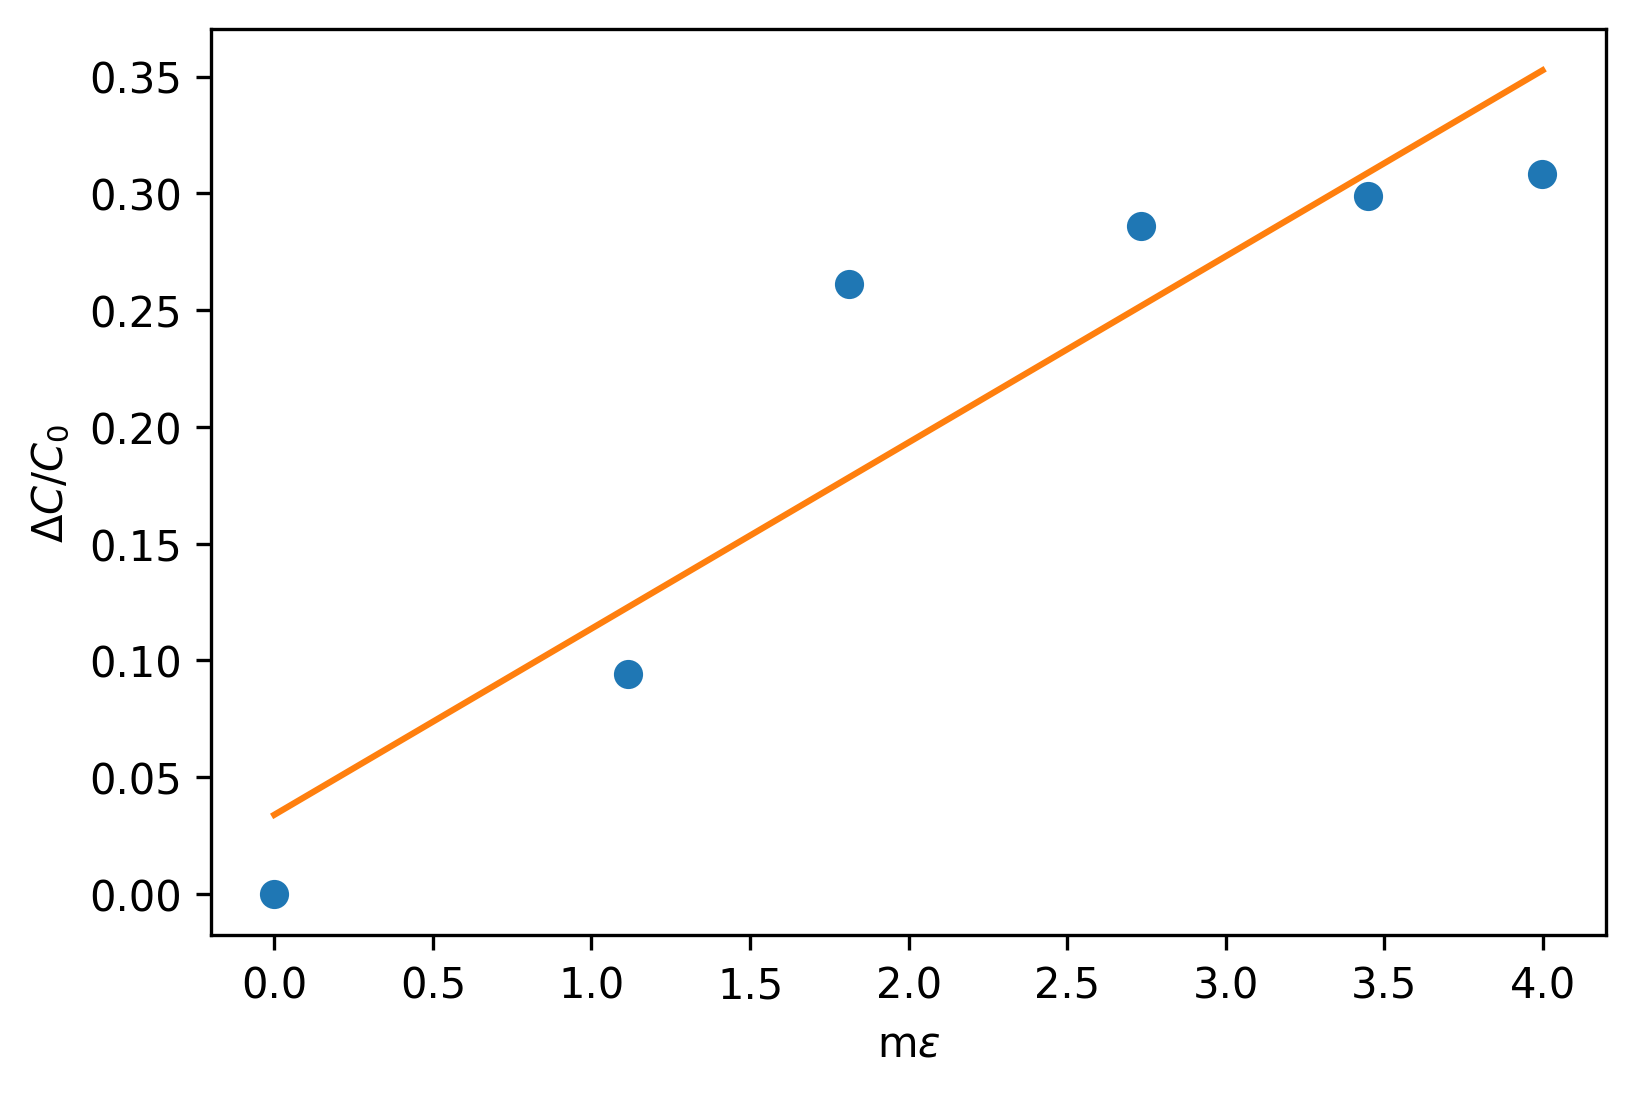

In [ ]:
strain = np.array([0, 0.067, 0.1088, 0.1639, 0.2069, 0.2399]) # mm
force = np.array([0, 50, 100, 150, 200, 250]) * 9.8067 # N
C = np.array([237.732, 260.129, 299.794, 305.713, 308.772, 311.063]) # uF

e = strain / 60
C0 = C.min()
DC = C - C0
y = DC / C0

regre = sta.linregress(e, y)
plt.figure(dpi=300)
plt.plot(e*1e3, y, 'o')
plt.plot(e*1e3, regre.slope*e+regre.intercept)
plt.xlabel(r'm$\varepsilon$')
plt.ylabel(r'$\Delta C/C_0$')
regre.slope

In [ ]:
# v vs t
slopes_p40 = np.array([0.84996, 0.652643, 0.5944, 0.5876, 0.5164, 0.5229])
np.mean(slopes_p40)

# v vs pos
slopes_p40 = np.array([51.86, 39.86, 35.98, 35.22, 31.31, 31.72])
np.mean(slopes_p40)

# v vs f
slopes_p40 = np.array([4.1823, 3.2697, 2.8906, 2.8445, 2.5050, 2.5334])
np.mean(slopes_p40)

3.0375833333333335

In [ ]:
import numpy as np

lr1 = np.array([1.7, 1.83, 1.23])
lr2 = np.array([2.67, 2.07, 1.90])
lr1_mean = lr1.mean()
lr2_mean = lr2.mean()
100 - lr1_mean/lr2_mean *100

lc1 = np.array([-7.46, -3.84, -3.59])
lc2 = np.array([-3.87, -4.65, -6.74])
lc1_mean = lc1.mean()
lc2_mean = lc2.mean()
100 - lc1_mean/lc2_mean *100

print(r'lambda_m1 = %0.2f +/- %0.2f' %( lr1.mean(), lr1.std()) )
print(r'lambda_m2 = %0.2f +/- %0.2f' %( lr2.mean(), lr2.std()) )

print(r'lambda_C_m1 = %0.2f +/- %0.2f' %( lc1.mean(), lc1.std()) )
print(r'lambda_C_m2 = %0.2f +/- %0.2f' %( lc2.mean(), lc2.std()) )

lambda_m1 = 1.59 +/- 0.26
lambda_m2 = 2.21 +/- 0.33
lambda_C_m1 = -4.96 +/- 1.77
lambda_C_m2 = -5.09 +/- 1.21


In [ ]:
import numpy as np

Rm1 = np.array([2826.30, 2739.50, 3131.50])
Rm2 = np.array([2142.00, 2167.40, 2039.50])
Rm1_mean = Rm1.mean()
Rm2_mean = Rm2.mean()
100 - Rm2_mean/Rm1_mean *100
Rm1.mean(), Rm2.mean()

(2899.1, 2116.2999999999997)

In [ ]:
g33_1 = np.array([13.04, 14.97, 12.36, 9.87, 13.68, 10.55])
g33_2 = np.array([5.64, 3.66, 8.26, 5.77, 8.66, 10.98])

d33_1 = np.array([875.02, 1218.26, 1368.36, 950.12, 1123.48, 985.80])
d33_2 = np.array([724.82, 433.86, 1178.92, 620.66, 1104.00, 862.20])

e_1 = np.array([32.58, 40.40, 50.68, 33.29, 32.70, 47.13])
e_2 = np.array([8.51, 9.10, 19.17, 13.3, 9.72, 58.42])

print(r'g33_m1 = %0.2f +/- %0.2f' %( g33_1.mean(), g33_1.std()) )
print(r'g33_m2 = %0.2f +/- %0.2f' %( g33_2.mean(), g33_2.std()) )

print(r'd33_m1 = %0.2f +/- %0.2f' %( d33_1.mean(), d33_1.std()) )
print(r'd33_m2 = %0.2f +/- %0.2f' %( d33_2.mean(), d33_2.std()) )

print(r'energy_m1 = %0.2f +/- %0.2f' %( e_1.mean(), e_1.std()) )
print(r'energy_m2 = %0.2f +/- %0.2f' %( e_2.mean(), e_2.std()) )

g33_m1 = 12.41 +/- 1.75
g33_m2 = 7.16 +/- 2.40
d33_m1 = 1086.84 +/- 169.13
d33_m2 = 820.74 +/- 261.14
energy_m1 = 39.46 +/- 7.27
energy_m2 = 19.70 +/- 17.69


# 5.0. Saving figures and paths

In [ ]:
base_path = 'outputs/fig_GO/' # ruta base para guardar .png y .xls
dpi_save = 300 # resolución en pixel con que será guardada la figura.
df_dataA = pd.DataFrame([]) # DataFrame con resultados de los análisis de datos y gráficas.
df_fig_path = pd.DataFrame([]) # DataFrame con paths de las figuras separados por tipos de gráfica.

try: # se llaman archivos .xlsx con cálculos y paths de las figuras, si no existen sigue ejecutando el código.
  df_dataA = pd.read_excel(base_path+'dataA_GO.xlsx', sheet_name="analytics")
  df_fig_path = pd.read_excel(base_path+'fig_GO.xlsx', sheet_name="figs")
except:
  pass

tmi = []
tma = []
sample = ''
for ss3 in picked_samples: # nombre de muestra. 
  tmi = np.append(tmi, idata[ss3][0].min())
  tma = np.append(tma, idata[ss3][0].max())
  sample = ss3+'_'+sample

tmin = '%0.2f' % np.mean(tmi) # tiempo inicial.
tmax = '%0.2f' % np.mean(tma) # tiempo final.

#tmin = '%0.2f' % idata[ss3][0].min() # tiempo inicial.
#tmax = '%0.2f' % idata[ss3][0].max() # tiempo final.

  # metodología para nombrar figuras en base al nombre de la muestra, tipo de gráfico
  # y rango de tiempo representado.
xl = xylabel[0]
yl = xylabel[1]
fig_name = sample+yl.split()[0]+'_'+xl.split()[0]+'_'+tmin+'_to_'+tmax+'.png'

xylabel[2].savefig(base_path+fig_name, dpi=dpi_save) # guardando figura.

column = yl+' vs '+xl # columna donde se etiquetará el titulo de la figura.

  # pregunta si el encabezado de la columna se encuentra en el DataFrame cargado.
k = df_fig_path.columns == column
if k.sum() == 1:  
  ds = df_fig_path[column] # convierte columna en DataSeries
  idx = ds.last_valid_index() # último indice con celda escrita en el DataSeries
  if df_fig_path.at[idx, column] != base_path+fig_name: # Evita repetir path
    df_fig_path.at[idx+1, column] = base_path+fig_name # escribiendo el path de la figura.
else:
  df_fig_path.at[0, column] = base_path+fig_name # escribiendo el path de la figura.

# Se crean archivos .xlsx con cálculos y paths de las figuras.
df_dataA.to_excel(base_path+'dataA_GO.xlsx', sheet_name='analytics', index=False)
df_fig_path.to_excel(base_path+'fig_GO.xlsx', sheet_name='figs', index=False)

In [ ]:
df_fig_path

,Deformación [mm] vs Tiempo [s],Fuerza [kN] vs Deformación [mm],Voltaje [mV] vs Tiempo [s],Corriente [$\mu$A] vs Tiempo [s],Corriente [$\mu$A] vs Deformación [mm],Voltaje [mV] vs Deformación unitaria [$\mu \epsilon$],Resistencia [k$\Omega$] vs Deformación unitaria [$\mu \epsilon$],Voltage [mV] vs Time [s],Voltage [mV] vs Load [kN],Voltage [mV] vs Load [N],Strain [$\mu \epsilon$] vs Time [s],Power [nW] vs Time [s],Current [$\mu$A] vs Time [s],$\frac{\Delta R}{R_0}$ vs Time [s],Resistance [k$\Omega$] vs Time [s],$\frac{\Delta R}{R_0}$ [$\Omega/\Omega$] vs Strain [$\mu \epsilon$],Power [nW] vs Strain [$\mu \epsilon$],Voltage [mV] vs Strain [$\mu \epsilon$],$\Delta R/R_0$ [$\Omega/\Omega$] vs Strain [$\mu \epsilon$],Current [$\mu$A] vs Strain [$\mu \epsilon$]
0,outputs/fig_GO/p40_p39_Deformación_Tiempo_2.36...,outputs/fig_GO/p40_p39_Fuerza_Deformación_2.36...,outputs/fig_GO/p40_p39_Voltaje_Tiempo_2.36_to_...,outputs/fig_GO/p40_p39_Corriente_Tiempo_2.36_t...,outputs/fig_GO/p41_p40_p39_Corriente_Deformaci...,outputs/fig_GO/p40_Voltaje_Deformación_2.16_to...,outputs/fig_GO/p40_Resistencia_Deformación_2.1...,outputs/fig_GO/p44_p43_p42_p41_p40_p39_Voltage...,outputs/fig_GO/p39_Voltage_Load_2.56_to_16.00.png,outputs/fig_GO/p44_p41_p40_Voltage_Load_2.22_t...,outputs/fig_GO/p39_Strain_Time_2.56_to_150.00.png,outputs/fig_GO/p39_Power_Time_2.56_to_150.00.png,outputs/fig_GO/p40_Current_Time_2.16_to_150.00...,outputs/fig_GO/p39_$\frac{\Delta_Time_2.56_to_...,outputs/fig_GO/p39_Resistance_Time_2.56_to_150...,outputs/fig_GO/p39_$\frac{\Delta_Strain_2.56_t...,outputs/fig_GO/p39_Power_Strain_2.56_to_130.00...,outputs/fig_GO/p39_Voltage_Strain_2.56_to_130....,outputs/fig_GO/p39_$\Delta_Strain_2.56_to_130....,outputs/fig_GO/p39_Current_Strain_2.56_to_130....
1,NaN,NaN,outputs/fig_GO/p42_p41_Voltaje_Tiempo_2.26_to_...,outputs/fig_GO/p42_p41_Corriente_Tiempo_2.26_t...,NaN,NaN,NaN,outputs/fig_GO/p40_Voltage_Time_2.16_to_156.16...,outputs/fig_GO/p44_p43_p42_p41_p40_p39_Voltage...,outputs/fig_GO/p49_p48_p45_Voltage_Load_2.62_t...,NaN,outputs/fig_GO/p40_Power_Time_2.16_to_150.00.png,outputs/fig_GO/p39_Current_Time_2.56_to_150.00...,NaN,NaN,NaN,outputs/fig_GO/p39_Power_Strain_2.56_to_140.00...,NaN,outputs/fig_GO/p39_$\Delta_Strain_2.56_to_154....,NaN
2,NaN,NaN,outputs/fig_GO/p44_p43_Voltaje_Tiempo_2.36_to_...,outputs/fig_GO/p44_p43_Corriente_Tiempo_2.36_t...,NaN,NaN,NaN,outputs/fig_GO/p42_Voltage_Time_2.36_to_142.00...,NaN,outputs/fig_GO/p44_p41_p40_Voltage_Load_2.22_t...,NaN,outputs/fig_GO/p41_Power_Time_2.16_to_146.16.png,outputs/fig_GO/p40_Current_Time_2.16_to_150.00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,outputs/fig_GO/p44_p43_p42_p41_Voltaje_Tiempo_...,outputs/fig_GO/p44_p43_p42_p41_Corriente_Tiemp...,NaN,NaN,NaN,outputs/fig_GO/p39_Voltage_Time_2.56_to_150.00...,NaN,outputs/fig_GO/p39_Voltage_Load_2.56_to_13.00.png,NaN,outputs/fig_GO/p42_Power_Time_2.36_to_142.00.png,outputs/fig_GO/p41_Current_Time_2.16_to_146.16...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,outputs/fig_GO/p50_p49_p48_p47_Voltaje_Tiempo_...,outputs/fig_GO/p50_p49_p48_p47_Corriente_Tiemp...,NaN,NaN,NaN,outputs/fig_GO/p45_Voltage_Time_2.76_to_141.76...,NaN,NaN,NaN,outputs/fig_GO/p43_Power_Time_2.36_to_150.00.png,outputs/fig_GO/p45_Current_Time_2.76_to_141.76...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,outputs/fig_GO/p41_p40_p39_Voltaje_Tiempo_2.29...,NaN,NaN,NaN,NaN,outputs/fig_GO/p46_Voltage_Time_2.76_to_150.00...,NaN,NaN,NaN,outputs/fig_GO/p44_Power_Time_2.36_to_150.00.png,outputs/fig_GO/p39_Current_Time_2.56_to_150.00...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outputs/fig_GO/p50_Voltage_Time_2.16_to_150.00...,NaN,NaN,NaN,outputs/fig_GO/p46_Power_Time_2.76_to_150.00.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outputs/fig_GO/p47_Voltage_Time_2.56_to_150.00...,NaN,NaN,NaN,outputs/fig_GO/p47_Power_Time_2.56_to_150.00.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,outputs/fig_GO/p48_Voltage_Time_2.36_to_146.00...,NaN,NaN,NaN,outputs/fi

# 7.0. Analysis particle size distribution

100    391.279669
Name: Unnamed: 5, dtype: object 14.6776997906788
118    1681.330577
Name: Unnamed: 5, dtype: object 14.8640867581004


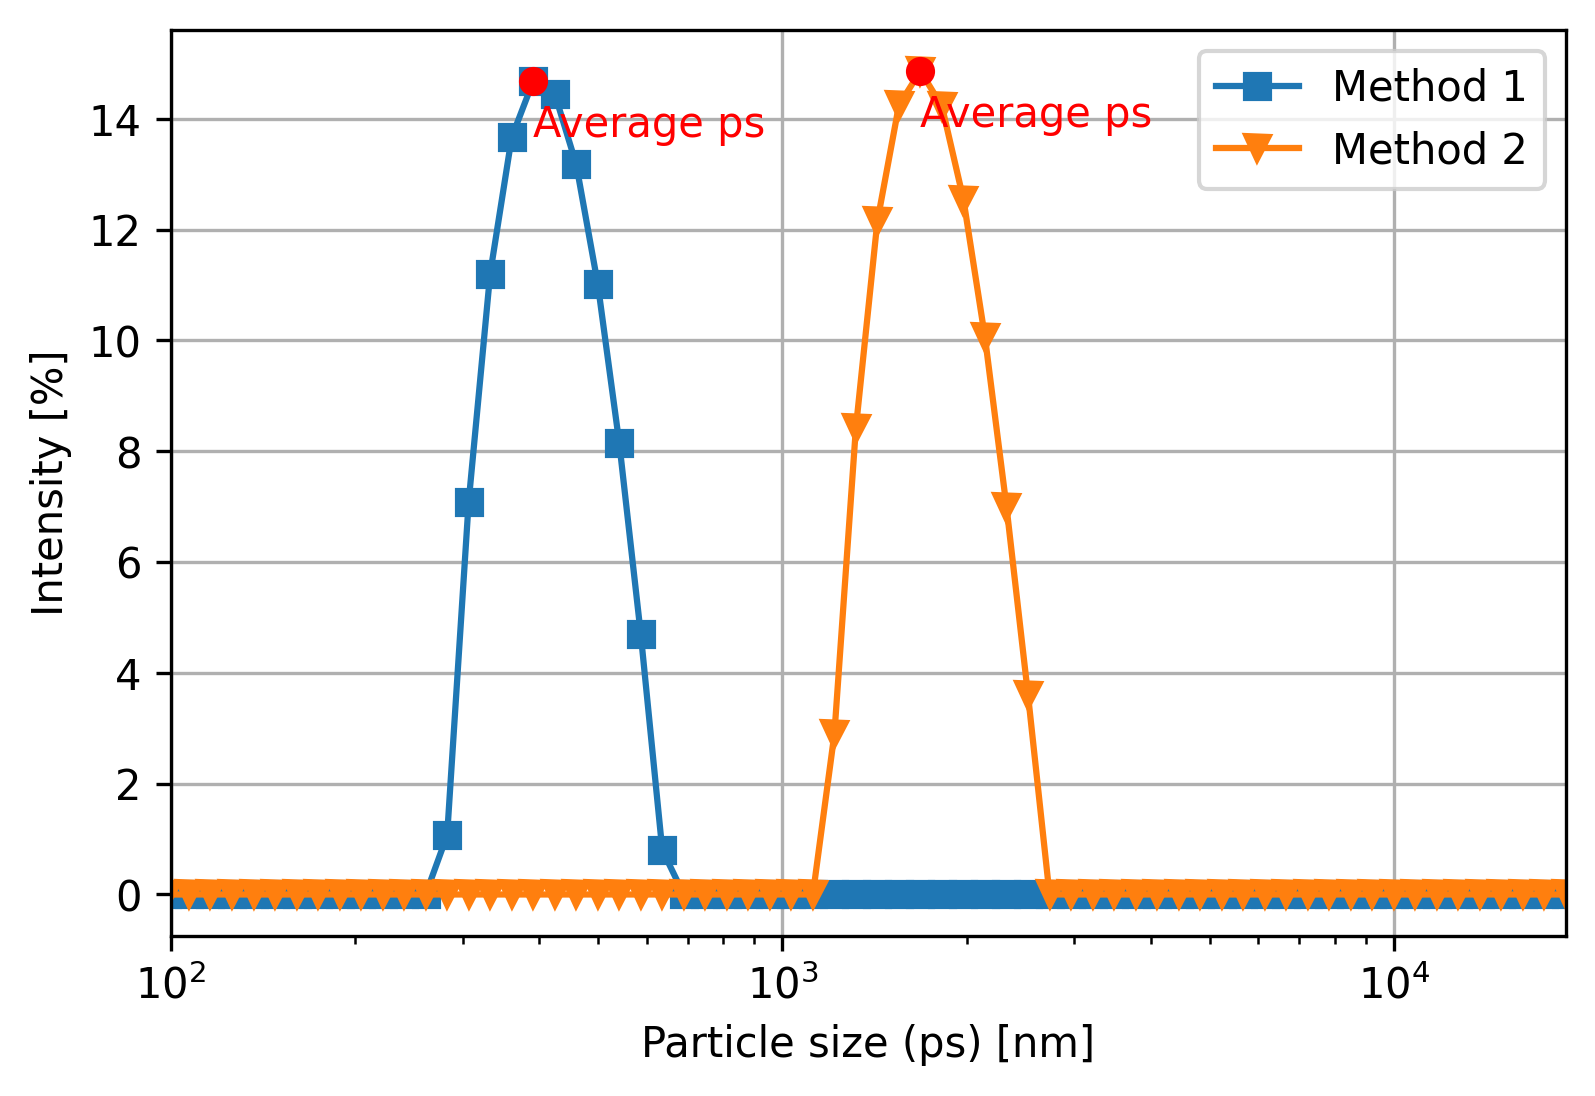

In [ ]:
fig_save_path = 'outputs/fig_GO'
dpi = 300
measurement = 'Measurement 1', 'Measurement 2', 'Measurement 3'
#measu_type = 'AuNPs', 'GONPs', 'GraphiteNPs'
file_name = 'Daniel Triana_GONPs_Branson_90_20200306', 'Daniel Triana_GONPs_punta_90_20200306'
par_dia = 'Unnamed: 5' #Particle diameter [nm]
rel_int = 'Unnamed: 6' #Relative frequency Intensity weighted [%]
start_data = 7
end_data = 148
ps_fig_df = pd.DataFrame([])
time_line_df = pd.DataFrame([])

if not os.path.exists(fig_save_path):
  os.mkdir(fig_save_path)

index = -1
label = 'Method 1', 'Method 2'
mar = 's-', 'v-'
mea = [0, 2]
plt.figure(dpi=dpi)

for fn in file_name:
  index += 1
  data = pd.read_excel('data/20200306_DLS/'+fn+'.xlsx', sheet_name=measurement[mea[index]])
  ps = data.loc[start_data:end_data, par_dia]
  ri = data.loc[start_data:end_data, rel_int]
  peak = max(ri)
  s = ri == peak
  ps_max = ps[s]
  #time_line_df.at[index, 'time [days]'] = day
  #time_line_df.at[index, 'surfactant'] = dis
  #time_line_df.at[index, 'energy [kJ]'] = e
  #time_line_df.at[index, 'Intensity [%]'] = peak.values[0]
  #time_line_df.at[index, 'particle size [nm]'] = ps_max.values[0]
  plt.plot(ps, ri, mar[index], label=label[index])
  plt.plot(ps_max, peak, 'or')
  print(ps_max, peak)
  plt.text(ps_max, peak-1, 'Average ps', color='red')

plt.xlim(1e2, ps.max())
plt.xscale('log')
plt.xlabel('Particle size (ps) [nm]')
plt.ylabel('Intensity [%]')

fig_path = os.path.join(fig_save_path, u'ps_GO.png')
plt.legend()
plt.grid()
#plt.title('DLS_day_'+day)
plt.savefig(fig_path, dpi=dpi)

#plt.close()
#ps_fig_df.at[index_f, 'energy'] = e
#ps_fig_df.at[index_f, 'ps_day_'+day] = fig_path  
    
#time_line_df.to_excel('outputs/time_line_ps.xlsx', sheet_name='data', index=False)
#print(time_line_df)
#ps_fig_df.to_excel('outputs/ps_fig.xlsx', sheet_name='plots', index=False)
#ps_fig_df

# 8.0. Stair mechanical load

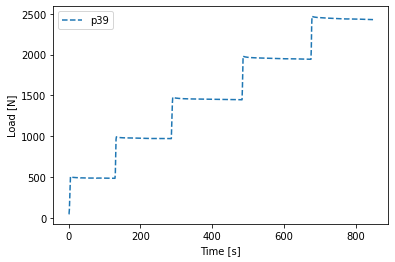

In [ ]:
m_data = pd.read_excel('data/20220406_f_Malaga/fc_p39.xlsx')
fig_save_path = 'outputs/fig_GO'
fig_path = os.path.join(fig_save_path, u'stair_GO.png')
file_data = open(fig_save_path+'/stair_GO.txt', mode='w+')
dpi=300

m_data.columns = m_data.iloc[1]
m_data = m_data.drop([0,1,2])
m_t = m_data['Tiempo'].values # Segundos
f = m_data['Fuerza'].values*9.8067 # N
pos = m_data['Posición'].values # mm

for s in np.arange(len(m_t)):
   file_data.write('%0.3f %0.3f\n' %(m_t[s], f[s]))
file_data.close()

plt.plot(m_t, f, '--', label='p39')
plt.xlabel('Time [s]')
plt.ylabel('Load [N]')
plt.legend()

plt.savefig(fig_path, dpi=dpi)
#plt.close()